# Bibliotecas

In [3]:
pip install seaborn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 1. Importação das bibliotecas

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, min, max, variance, when, month, dayofweek, hour, minute, year, to_timestamp, to_date
from pyspark.sql.functions import concat, lit, substring, lpad, format_string, sum, when, trim, upper, desc
from pyspark.sql.functions import unix_timestamp, datediff
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import folium
from folium.plugins import HeatMap
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

# 2. Configuração do Spark


spark = SparkSession.builder \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .appName("CrimeDataAnalysis_Fase3") \
    .getOrCreate()

# 3. Carregamento do Dataset

file_path = "/content/drive/My Drive/Crime_Data_Selected_final_final.csv"
df_new=spark.read.csv(file_path, header=True, inferSchema=True, sep=";")
# Configurar o Spark para evitar erro de parsing
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# 6. Treino do modelo

In [6]:
df_new.show(5)

+----------------------+-------------+-------------+-------------------+---------+-----------+-----------------+----------+--------------------+----------+----------+--------------------+------------+-----------+------------------+------------+--------------------+---------+----+---+---------+----+------------+-------------+--------------+---------+
|Report_District_Number|Date_Reported|Date_Occurred|      Time_Occurred|Area_Code|  Area_Name|Part1_2_Indicator|Crime_Code|   Crime_Description|Victim_Age|Victim_Sex|      Victim_Descent|Premise_Code|Status_Code|Status_Description|Crime_Code_1|            Location|Longitude| Ano|Mes|DiaSemana|Hora|FinsDeSemana|Crime_Density|Hora_Categoria|�_Feriado|
+----------------------+-------------+-------------+-------------------+---------+-----------+-----------------+----------+--------------------+----------+----------+--------------------+------------+-----------+------------------+------------+--------------------+---------+----+---+---------+--

In [7]:
df_new = df_new.join(
    df_new.groupBy("Report_District_Number").agg(count("*").alias("Crime_Count")),
    on="Report_District_Number",
    how="left"
)

# Verify it worked
df_new.select("Report_District_Number", "Crime_Count").show(5)

+----------------------+-----------+
|Report_District_Number|Crime_Count|
+----------------------+-----------+
|                  1645|        396|
|                  1591|       1487|
|                  1342|        839|
|                   148|        612|
|                   148|        612|
+----------------------+-----------+
only showing top 5 rows



In [8]:
df_new = df_new.withColumn("Crime_Zone_Multi",
    when(df_new["Crime_Count"] <= 800, 0)    # Baixa criminalidade
    .when((df_new["Crime_Count"] > 800) & (df_new["Crime_Count"] <= 1300), 1)  # Média
    .when((df_new["Crime_Count"] > 1300) & (df_new["Crime_Count"] <= 1800), 2)  # Alta
    .otherwise(3)  # Muito alta
)

# Verificar a distribuição das classes
df_new.groupBy("Crime_Zone_Multi").count().show()

+----------------+------+
|Crime_Zone_Multi| count|
+----------------+------+
|               1|258739|
|               3|221857|
|               2|156567|
|               0|307051|
+----------------+------+



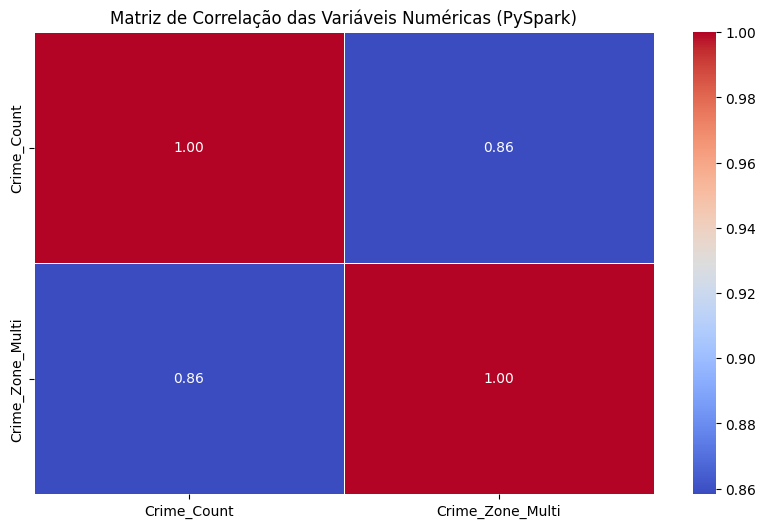

In [9]:
# Definir as colunas numéricas para análise de correlação
numeric_cols = ["Crime_Count", "Crime_Zone_Multi"]

# Criar o vetor de características para a correlação
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_new).select(vector_col)

# Calcular a matriz de correlação
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0]

# Converter para array numpy
corr_array = np.array(correlation_matrix.toArray())

# Criar o heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_array, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Matriz de Correlação das Variáveis Numéricas (PySpark)")
plt.show()

In [10]:
df_new.printSchema()

root
 |-- Report_District_Number: integer (nullable = true)
 |-- Date_Reported: string (nullable = true)
 |-- Date_Occurred: string (nullable = true)
 |-- Time_Occurred: timestamp (nullable = true)
 |-- Area_Code: integer (nullable = true)
 |-- Area_Name: string (nullable = true)
 |-- Part1_2_Indicator: integer (nullable = true)
 |-- Crime_Code: integer (nullable = true)
 |-- Crime_Description: string (nullable = true)
 |-- Victim_Age: integer (nullable = true)
 |-- Victim_Sex: string (nullable = true)
 |-- Victim_Descent: string (nullable = true)
 |-- Premise_Code: integer (nullable = true)
 |-- Status_Code: string (nullable = true)
 |-- Status_Description: string (nullable = true)
 |-- Crime_Code_1: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Ano: integer (nullable = true)
 |-- Mes: integer (nullable = true)
 |-- DiaSemana: integer (nullable = true)
 |-- Hora: integer (nullable = true)
 |-- FinsDeSemana: integer (nul

In [11]:
num_cols = ["Area_Code","Victim_Age", "Crime_Code", "Crime_Zone_Multi"]

assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_new = assembler.transform(df_new)

df_final = df_new.select("Crime_Count", "features")

print(f"🚀 df_final tem {df_new.count()} linhas!")
df_final.show(5, truncate=False)

🚀 df_final tem 944214 linhas!
+-----------+---------------------+
|Crime_Count|features             |
+-----------+---------------------+
|396        |[16.0,16.0,813.0,0.0]|
|1487       |[15.0,14.0,820.0,2.0]|
|839        |[13.0,0.0,510.0,1.0] |
|612        |[1.0,0.0,341.0,0.0]  |
|612        |[1.0,31.0,354.0,0.0] |
+-----------+---------------------+
only showing top 5 rows



In [12]:
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)
print("🔥 Dados de treino e teste prontos!")

🔥 Dados de treino e teste prontos!


# 7. Modelação

## 7.1 Random Forest

In [13]:
#Criação do modelo

rf = RandomForestRegressor(featuresCol="features", labelCol="Crime_Count", numTrees=200, maxDepth=5)
model_rf = rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)

In [27]:
# Fazer previsões no conjunto de treino
predictions_train = model_rf.transform(train_data)

# Calcular métricas no treino
r2_train = evaluator_r2.evaluate(predictions_train)
rmse_train = evaluator_rmse.evaluate(predictions_train)
mae_train = evaluator_mae.evaluate(predictions_train)

# Exibir resultados do treino e teste
print(f"R² no treino: {r2_train}")
print(f"RMSE no treino: {rmse_train}")
print(f"MAE no treino: {mae_train}\n")

R² no treino: 0.8107294101865609
RMSE no treino: 377.28321026964073
MAE no treino: 226.22072411072665



In [24]:
# Mostrar algumas previsões no conjunto de teste
predictions_rf.select("Crime_Count", "prediction").show(10)

# Criar o avaliador de regressão
evaluator_r2 = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="mae")

# Calcular métricas
r2_test = evaluator_r2.evaluate(predictions_rf)
rmse_test = evaluator_rmse.evaluate(predictions_rf)
mae_test = evaluator_mae.evaluate(predictions_rf)

# Exibir resultados
print(f"R² no teste: {r2_test}")
print(f"RMSE no teste: {rmse_test}")
print(f"MAE no teste: {mae_test}")

+-----------+-----------------+
|Crime_Count|       prediction|
+-----------+-----------------+
|          1|652.0494061688172|
|          1|606.1926718997497|
|          1|605.8452704389572|
|          1|606.3856737762935|
|          1|606.3146556454126|
|          1|605.3329125515145|
|          1|600.8891662547738|
|          1|608.6524832759067|
|          1|608.2544575014567|
|          1|667.2249272416348|
+-----------+-----------------+
only showing top 10 rows

R² no teste: 0.8105589432079287
RMSE no teste: 376.17934769151805
MAE no teste: 225.5487334774827


<ipython-input-32-691004c4383c>:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


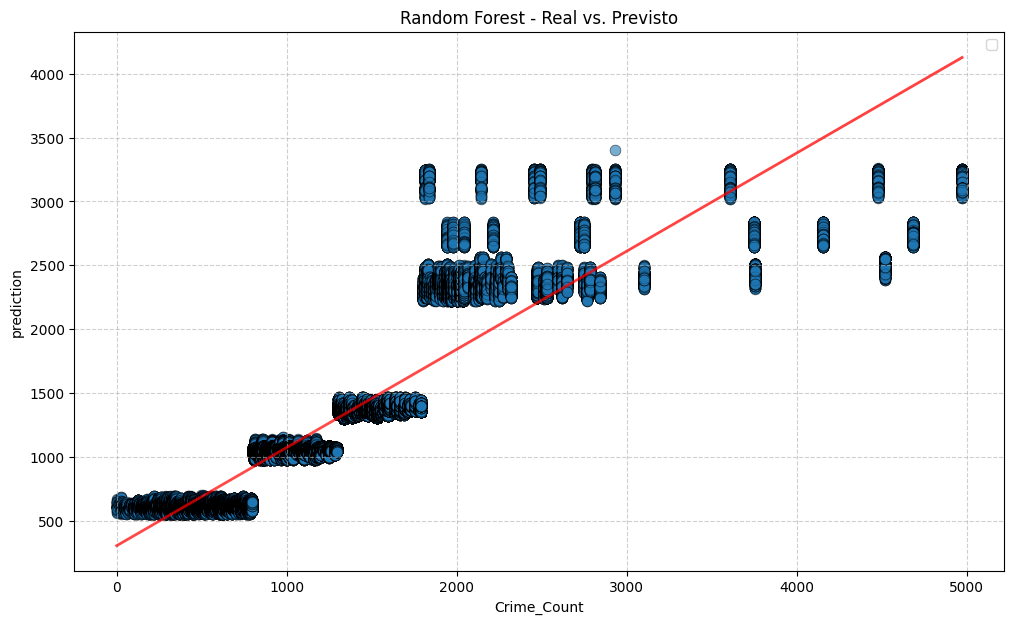

In [32]:
#  Converter Crime_Count e prediction explicitamente para float
predictions_pd["Crime_Count"] = predictions_pd["Crime_Count"].astype(float)
predictions_pd["prediction"] = predictions_pd["prediction"].astype(float)


plt.figure(figsize=(12, 7))

#  Melhorar a visualização dos pontos
sns.scatterplot(
    x=predictions_pd["Crime_Count"],
    y=predictions_pd["prediction"],
    alpha=0.6,
    edgecolor="black",
    linewidth=0.5,
    s=60
)


#  Melhorias nos eixos e título
plt.xlabel("Crime Real")
plt.ylabel("Crime Previsto")
plt.title("Random Forest - Real vs. Previsto")

#  Melhorar visualização do grid
plt.grid(True, linestyle="--", alpha=0.6)

#Linha de tendência
sns.regplot(
    x=predictions_pd["Crime_Count"],
    y=predictions_pd["prediction"],
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "alpha": 0.7}
)

#  Adicionar legenda
plt.legend()

#  Exibir gráfico
plt.show()


## 7.2 Gradient Boosting

In [40]:
# Criar e treinar o modelo GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="Crime_Count", maxIter=50, maxDepth=5)
model_gbt = gbt.fit(train_data)

# Fazer previsões no conjunto de treino
train_predictions_gbt = model_gbt.transform(train_data)

# Avaliadores
evaluator_r2 = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="mae")

# Métricas de avaliação
r2_train = evaluator_r2.evaluate(train_predictions_gbt)
rmse_train = evaluator_rmse.evaluate(train_predictions_gbt)
mae_train = evaluator_mae.evaluate(train_predictions_gbt)

# Exibir métricas
print("=" * 40)
print("GBTRegressor - Avaliação no Treino")
print("=" * 40)
print(f"R²   : {r2_train:.4f}")
print(f"RMSE : {rmse_train:.4f}")
print(f"MAE  : {mae_train:.4f}")
print("=" * 40)

# Criar dicionário de resultados para armazenar métricas
if 'results' not in locals():
    results = {}

results["GBTRegressor_Treino"] = {"R²": r2_train, "RMSE": rmse_train, "MAE": mae_train}

📊 GBTRegressor - Avaliação no Treino 📊
🔹 R²   : 0.8501
🔹 RMSE : 335.7059
🔹 MAE  : 200.6475


In [41]:
#  Fazer previsões no conjunto de teste
predictions_gbt = model_gbt.transform(test_data)

# Calcular métricas de avaliação no TESTE
r2_gbt = evaluator_r2.evaluate(predictions_gbt)
rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
mae_gbt = evaluator_mae.evaluate(predictions_gbt)

# Exibir métricas de forma organizada
print("=" * 40)
print("GBTRegressor - Avaliação no Teste")
print("=" * 40)
print(f"R²   : {r2_gbt:.4f}")
print(f"RMSE : {rmse_gbt:.4f}")
print(f"MAE  : {mae_gbt:.4f}")
print("=" * 40)

# Armazenar resultados no dicionário
results["GBTRegressor_Teste"] = {"R²": r2_gbt, "RMSE": rmse_gbt, "MAE": mae_gbt}

# Criar DataFrame dos resultados
results_df = pd.DataFrame.from_dict(results, orient="index")

# Exibir tabela comparativa dos modelos
print("Comparação dos Modelos (Treino vs. Teste):")
print(results_df)

📊 GBTRegressor - Avaliação no Teste 📊
🔹 R²   : 0.8489
🔹 RMSE : 335.9650
🔹 MAE  : 200.5067

📌 Comparação dos Modelos (Treino vs. Teste):
                           R²        RMSE         MAE
GBTRegressor         0.848897  335.965019  200.506735
GBTRegressor_Treino  0.850147  335.705945  200.647461
GBTRegressor_Teste   0.848897  335.965019  200.506735


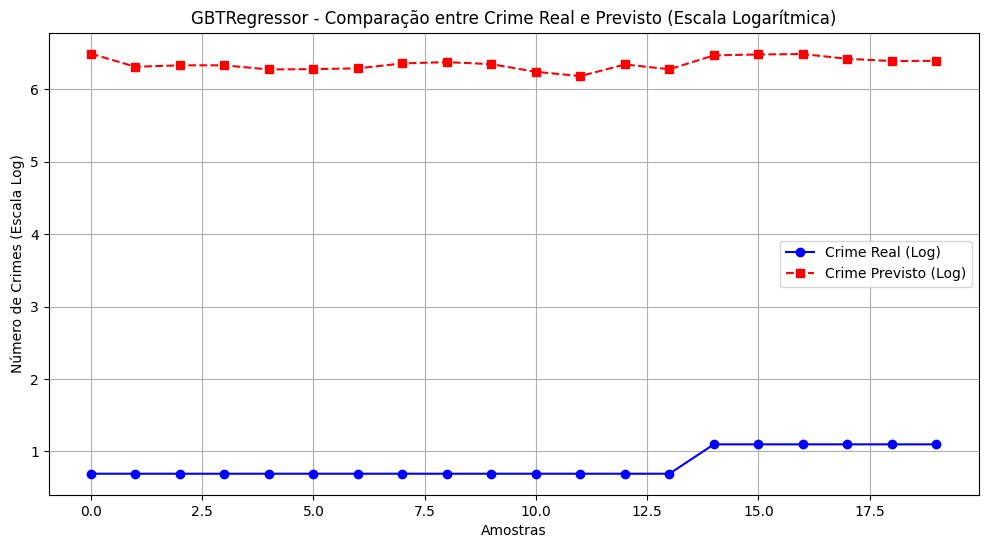

In [43]:
# Converter previsões para Pandas
predictions_gbt_pd = predictions_gbt.select("Crime_Count", "prediction").toPandas()

# Converter colunas para valores numéricos
predictions_gbt_pd["Crime_Count"] = pd.to_numeric(predictions_gbt_pd["Crime_Count"], errors="coerce")
predictions_gbt_pd["prediction"] = pd.to_numeric(predictions_gbt_pd["prediction"], errors="coerce")

# Remover valores nulos (NaN)
predictions_gbt_pd = predictions_gbt_pd.dropna()

# Selecionar apenas as 20 primeiras previsões para facilitar a visualização
predictions_gbt_pd = predictions_gbt_pd.head(20)

# Aplicar escala logarítmica para evitar distorções e tratar valores pequenos
predictions_gbt_pd["Crime_Count_Log"] = np.log1p(predictions_gbt_pd["Crime_Count"])  # log(1 + x)
predictions_gbt_pd["prediction_Log"] = np.log1p(predictions_gbt_pd["prediction"])

# Criar gráfico de linhas para melhor visualização
plt.figure(figsize=(12, 6))

plt.plot(predictions_gbt_pd.index, predictions_gbt_pd["Crime_Count_Log"], marker="o", linestyle="-", color="blue", label="Crime Real (Log)")
plt.plot(predictions_gbt_pd.index, predictions_gbt_pd["prediction_Log"], marker="s", linestyle="--", color="red", label="Crime Previsto (Log)")

# Melhorias no gráfico
plt.xlabel("Amostras")
plt.ylabel("Número de Crimes (Escala Log)")
plt.title("GBTRegressor - Comparação entre Crime Real e Previsto (Escala Logarítmica)")
plt.legend()
plt.grid(True)

# Exibir gráfico
plt.show()

Pela interpretação do gráfico há evidências claras de que o modelo não está a conseguir lidar com os dados, pois há uma grande distância entre a linha de tendência do crime real e a linha de tendência do crime previsto. Isto pode indicar que o modelo superestimou os valores reais.

Com isto surge a necessidade de criar um gráfico de resíduos para perceber melhor onde é que o modelo errou mais.

### Gráfico de Resíduos

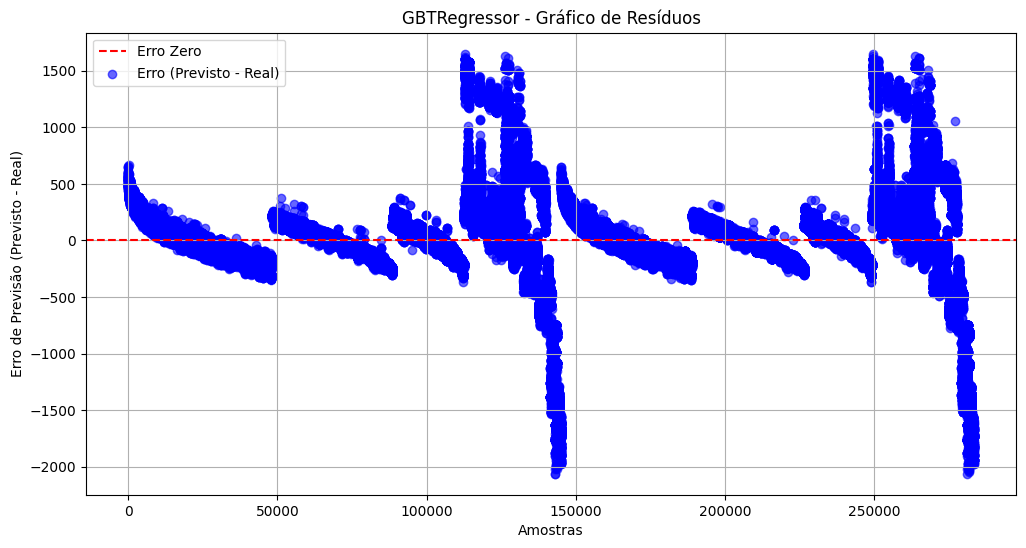

In [50]:
# Converter previsões do GBT para Pandas
predictions_gbt_pd = predictions_gbt.select("Crime_Count", "prediction").toPandas()

# Converter colunas para valores numéricos
predictions_gbt_pd["Crime_Count"] = pd.to_numeric(predictions_gbt_pd["Crime_Count"], errors="coerce")
predictions_gbt_pd["prediction"] = pd.to_numeric(predictions_gbt_pd["prediction"], errors="coerce")

# Remover valores nulos (NaN)
predictions_gbt_pd = predictions_gbt_pd.dropna()

# Criar a coluna de erro (Previsto - Real)
predictions_gbt_pd["Erro"] = predictions_gbt_pd["prediction"] - predictions_gbt_pd["Crime_Count"]

# Criar o gráfico de resíduos
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label="Erro Zero")  # Linha de referência

plt.scatter(predictions_gbt_pd.index, predictions_gbt_pd["Erro"], color='blue', alpha=0.6, label="Erro (Previsto - Real)")

# Melhorias no gráfico
plt.xlabel("Amostras")
plt.ylabel("Erro de Previsão (Previsto - Real)")
plt.title("GBTRegressor - Gráfico de Resíduos")
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

## 7.3 Regressão Linear

In [36]:
lr = LinearRegression(featuresCol="features", labelCol="Crime_Count", regParam=0.1, elasticNetParam=0.5)
model_lr = lr.fit(train_data)
predictions_lr = model_lr.transform(test_data)

In [46]:
# Criar e treinar o modelo de Regressão Linear
lr = LinearRegression(featuresCol="features", labelCol="Crime_Count", regParam=0.1, elasticNetParam=0.5)
model_lr = lr.fit(train_data)

# Fazer previsões no conjunto de treino
train_predictions_lr = model_lr.transform(train_data)

# Fazer previsões no conjunto de teste
predictions_lr = model_lr.transform(test_data)

# Criar avaliadores
evaluator_r2 = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="Crime_Count", predictionCol="prediction", metricName="mae")

# Calcular métricas no treino
r2_train = evaluator_r2.evaluate(train_predictions_lr)
rmse_train = evaluator_rmse.evaluate(train_predictions_lr)
mae_train = evaluator_mae.evaluate(train_predictions_lr)

# Calcular métricas no teste
r2_test = evaluator_r2.evaluate(predictions_lr)
rmse_test = evaluator_rmse.evaluate(predictions_lr)
mae_test = evaluator_mae.evaluate(predictions_lr)

# Exibir métricas organizadas
print("=" * 50)
print("Regressão Linear - Avaliação do Modelo")
print("=" * 50)
print(f"R² (Treino)  : {r2_train:.4f}")
print(f"RMSE (Treino): {rmse_train:.4f}")
print(f"MAE (Treino) : {mae_train:.4f}")
print("-" * 50)
print(f"R² (Teste)   : {r2_test:.4f}")
print(f"RMSE (Teste) : {rmse_test:.4f}")
print(f"MAE (Teste)  : {mae_test:.4f}")
print("=" * 50)

# Criar dicionário de resultados
results = {
    "LinearRegression_Treino": {"R²": r2_train, "RMSE": rmse_train, "MAE": mae_train},
    "LinearRegression_Teste": {"R²": r2_test, "RMSE": rmse_test, "MAE": mae_test}
}

# Criar DataFrame com os resultados
results_df = pd.DataFrame.from_dict(results, orient="index")

# Exibir tabela comparativa dos modelos
print("Comparação dos Modelos (Treino vs. Teste):")
print(results_df)

Regressão Linear - Avaliação do Modelo
R² (Treino)  : 0.7400
RMSE (Treino): 442.1752
MAE (Treino) : 269.3865
--------------------------------------------------
R² (Teste)   : 0.7409
RMSE (Teste) : 439.9275
MAE (Teste)  : 268.1270
Comparação dos Modelos (Treino vs. Teste):
                               R²        RMSE         MAE
LinearRegression_Treino  0.740022  442.175191  269.386501
LinearRegression_Teste   0.740912  439.927521  268.126983


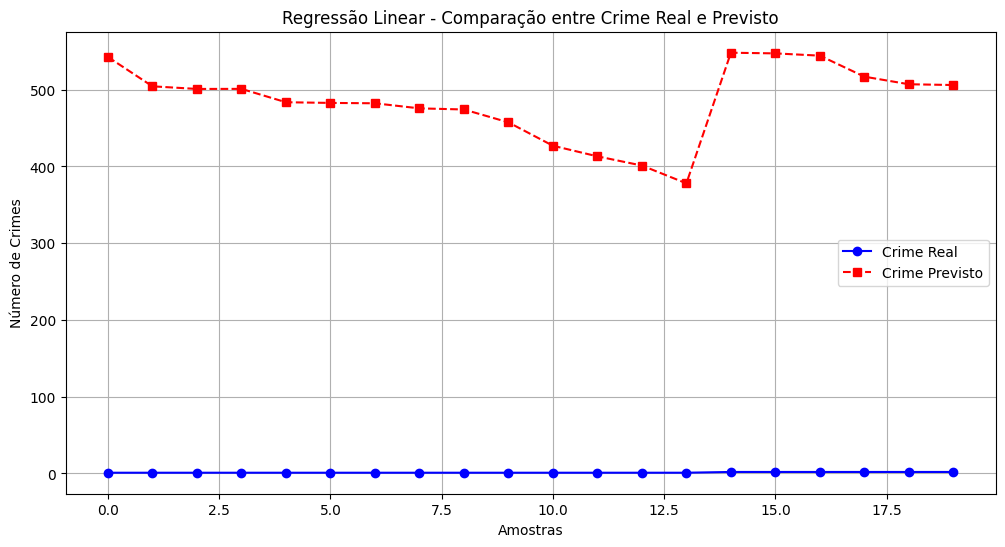

In [47]:
# Converter previsões para Pandas
predictions_lr_pd = predictions_lr.select("Crime_Count", "prediction").toPandas()

# Converter colunas para valores numéricos
predictions_lr_pd["Crime_Count"] = pd.to_numeric(predictions_lr_pd["Crime_Count"], errors="coerce")
predictions_lr_pd["prediction"] = pd.to_numeric(predictions_lr_pd["prediction"], errors="coerce")

# Remover valores nulos (NaN)
predictions_lr_pd = predictions_lr_pd.dropna()

# Selecionar apenas as 20 primeiras previsões para facilitar a visualização
predictions_lr_pd = predictions_lr_pd.head(20)

# Criar gráfico de linhas para melhor visualização
plt.figure(figsize=(12, 6))

plt.plot(predictions_lr_pd.index, predictions_lr_pd["Crime_Count"], marker="o", linestyle="-", color="blue", label="Crime Real")
plt.plot(predictions_lr_pd.index, predictions_lr_pd["prediction"], marker="s", linestyle="--", color="red", label="Crime Previsto")

# Melhorias no gráfico
plt.xlabel("Amostras")
plt.ylabel("Número de Crimes")
plt.title("Regressão Linear - Comparação entre Crime Real e Previsto")
plt.legend()
plt.grid(True)

# Exibir gráfico
plt.show()

### Gráfico de resíduos

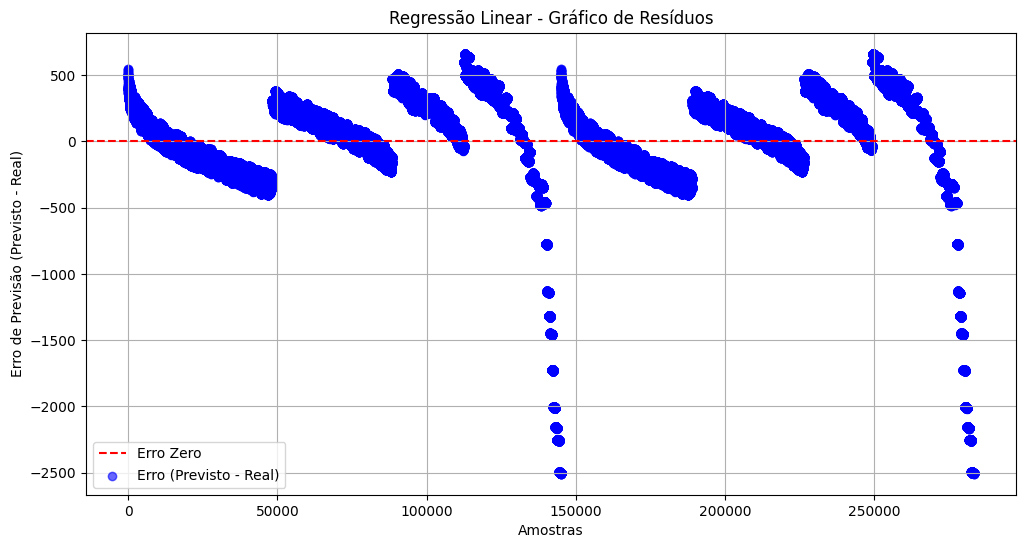

In [49]:
# Garantir que estamos usando o DataFrame correto
predictions_lr = model_lr.transform(test_data)

# Converter previsões para Pandas
predictions_lr_pd = predictions_lr.select("Crime_Count", "prediction").toPandas()

# Criar a coluna de erro (Previsto - Real)
predictions_lr_pd["Erro"] = predictions_lr_pd["prediction"] - predictions_lr_pd["Crime_Count"]

# Criar o gráfico de resíduos
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5, label="Erro Zero")  # Linha de referência

plt.scatter(predictions_lr_pd.index, predictions_lr_pd["Erro"], color='blue', alpha=0.6, label="Erro (Previsto - Real)")

# Melhorias no gráfico
plt.xlabel("Amostras")
plt.ylabel("Erro de Previsão (Previsto - Real)")
plt.title("Regressão Linear - Gráfico de Resíduos")
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()